In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sqlite3
from typing import List, Tuple, Dict
import warnings

Connect to the dataset

In [2]:
db = sqlite3.connect("aosp_acs.db")

Queries

In [3]:
def cursor_to_dataframe(cursor):
    with warnings.catch_warnings():
        # TODO: pandas 2.1.0 has a FutureWarning for concatenating DataFrames with Null entries
        warnings.filterwarnings("ignore", category=FutureWarning)
        columns = [desc[0] for desc in (cursor.description)]
        df_records = pd.DataFrame(columns=columns)
        for row in cursor:
            df_temp = pd.DataFrame([row], columns=columns)
            if df_temp.empty:
                continue
            df_records = pd.concat([df_records, df_temp])
    return df_records.reset_index(drop=True)

In [4]:
def acs_in_a_project(project_name) -> pd.DataFrame:
    cursor = db.execute("SELECT count(id) as ac_count,path,ac,loc FROM ac_reports WHERE path IN (SELECT path FROM files WHERE files.project_name = ?) GROUP BY path,ac",(project_name,))
    return cursor_to_dataframe(cursor)

def ck_in_a_project(project_name) -> pd.DataFrame:
    cursor = db.execute("SELECT * from classes WHERE file_path IN (SELECT path FROM files WHERE files.project_name = ?)", (project_name,))
    df = cursor_to_dataframe(cursor)
    NUMERIC_FIELDS = ['cbo', 'cboModified', 'fanin',
       'fanout', 'wmc', 'dit', 'noc', 'rfc', 'lcom', 'lcom_normalized', 'tcc',
       'lcc', 'totalMethodsQty', 'staticMethodsQty', 'publicMethodsQty',
       'privateMethodsQty', 'protectedMethodsQty', 'defaultMethodsQty',
       'visibleMethodsQty', 'abstractMethodsQty', 'finalMethodsQty',
       'synchronizedMethodsQty', 'totalFieldsQty', 'staticFieldsQty',
       'publicFieldsQty', 'privateFieldsQty', 'protectedFieldsQty',
       'defaultFieldsQty', 'finalFieldsQty', 'synchronizedFieldsQty', 'nosi',
       'loc', 'returnQty', 'loopQty', 'comparisonsQty', 'tryCatchQty',
       'parenthesizedExpsQty', 'stringLiteralsQty', 'numbersQty',
       'assignmentsQty', 'mathOperationsQty', 'variablesQty',
       'maxNestedBlocksQty', 'anonymousClassesQty', 'innerClassesQty',
       'lambdasQty', 'uniqueWordsQty', 'modifiers', 'logStatementsQty']
    for field in NUMERIC_FIELDS:
        df[field] = df[field].astype(float)
    return df


"""Prevalence report of AC in a project"""
def report_types_of_acs(project_name) -> dict:
    sql = f"SELECT ac, count(id) as qty FROM ac_reports WHERE project_name LIKE '{project_name}' GROUP BY ac ORDER BY qty DESC"
    cursor = db.execute(sql)
    return cursor_to_dataframe(cursor)

def files_in_a_project(project_name) -> pd.DataFrame:
    cursor = db.execute("SELECT * FROM files WHERE project_name = ?", (project_name,))
    return cursor_to_dataframe(cursor)

def loc_of_file(file_name) -> int:
    cursor = db.execute("SELECT loc FROM files WHERE path = ?", (file_name,))
    return int(next(cursor)[0])

def number_of_acs_in_files(project_name) -> dict:
    sql = f"""
    SELECT files.path, coalesce(ac_count, 0) AS count_acs
    FROM files
    LEFT JOIN
    (SELECT ac_reports.path AS ac_reports_path, count(id) AS ac_count
    FROM ac_reports
    WHERE project_name = '{project_name}'
    GROUP BY ac_reports.path)
    ON files.path = ac_reports_path
    WHERE files.project_name = '{project_name}'
    ORDER BY count_acs DESC;
    """
    cursor = db.execute(sql)
    return {k: v for k,v in cursor}

def report_files_with_acs(project_name) -> pd.Series:
    sql = f"SELECT DISTINCT path FROM ac_reports WHERE project_name = '{project_name}'"
    cursor = db.execute(sql)
    return pd.Series([tup[0] for tup in cursor])

def report_files_without_acs(project_name) -> pd.Series:
    sql = f"SELECT path FROM files WHERE project_name = '{project_name}'"
    cursor = db.execute(sql)
    all_files = [tup[0] for tup in cursor]
    files_with_ac = report_files_with_acs(project_name)
    return pd.Series([file for file in all_files if file not in files_with_ac])


In [5]:
def identity(x):
    return x

Get the list of core apps

In [6]:
cursor = db.execute("SELECT * FROM files WHERE path LIKE '/AOSP/packages/apps%';")
apps_set = set()
for path,loc, project_name in cursor:
    apps_set.add(project_name)

In [7]:
apps_data :Dict[str, Dict[str, pd.DataFrame]] = {}
for project in apps_set:
    apps_data[project] = {
        "ck": ck_in_a_project(project),
        "acs": acs_in_a_project(project),
        "files": files_in_a_project(project)
    }

print("Projects processed: ", len(apps_data.keys()))

Projects processed:  65


AVG, median, percentiles...

In [8]:
def process_ck(df: pd.DataFrame) -> pd.DataFrame:
    pd_recast_numeric = pd.DataFrame()
    output = pd.DataFrame()
    for col in df.columns:
        try:
            if col in ["id", "file_path"]:
                raise ValueError
            pd_recast_numeric[col] = pd.to_numeric(df[col])
            # output[f"{col}__mean"] = pd_recast_numeric[col].mean(skipna=True)
            # output[f"{col}__median"] = pd_recast_numeric[col].median(skipna=True)
            # output[f"{col}__90_perc"] = pd_recast_numeric[col].quantile(.90 )
        except ValueError:
            continue
        except Exception as e:
            print("Exception: ", e)
            print(f"Skipping column {col} of type {pd_recast_numeric[col].dtype}")
    return pd_recast_numeric.describe()

In [9]:
apps_data[project_name]["acs"].loc[apps_data[project_name]["acs"]["ac"] == "Logic as Control Flow"]["ac_count"].sum()

163

In [10]:
%%script echo skipping
def countacs(project_name: str) -> pd.DataFrame:
    loc_sum = apps_data[project_name]["files"]["loc"].sum()
    ac_count = apps_data[project_name]["acs"]["ac_count"].sum()
    loc_by_acs = loc_sum/ac_count if ac_count > 0 else -1
    return pd.DataFrame([(loc_sum, ac_count, loc_by_acs)], columns=["loc_sum", "ac_count", "loc_by_acs"])



df_apps_ac: pd.DataFrame = pd.DataFrame()
for idx, project_name in enumerate(apps_set):
    apps_ac_map = countacs(project_name)
    apps_ac_map = apps_ac_map.assign(project_name=[project_name])
    df_apps_ac = pd.concat([df_apps_ac, apps_ac_map])
df_apps_ac = df_apps_ac.reset_index(drop=True)

df_loc_by_acs = df_apps_ac.sort_values("loc_by_acs", ascending=True)

fig, ax = plt.subplots()


ax.bar(df_loc_by_acs["project_name"], df_loc_by_acs["loc_by_acs"], 0.9)
ax.figure.set_figwidth(12)
ax.figure.set_figheight(5)
ax.yaxis.set_label_text("Lines of code per AC")
ax.xaxis.set_label_text("Project Name")

plt.xticks(rotation=90)
plt.savefig("fig.png")


skipping


In [11]:
def plot_ac_report_bar(project_name):
    df_report = report_types_of_acs(project_name)
    df_report = df_report.assign(perc=(df_report["qty"] / df_report["qty"].sum()).astype(float).round(2))
    df_report = df_report.assign(label=df_report["ac"] + " " + df_report["perc"].astype(str))
    fig, ax = plt.subplots()
    ax.figure.set_figwidth(12)
    ax.figure.set_figheight(5)
    wedges, _ = ax.pie(df_report["perc"], wedgeprops=dict(width=0.5), startangle=0)

    # https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_and_donut_labels.html
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

    for i, p in enumerate(wedges):
        Epsilon = .00001
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        if ang == 180:
            ang = 179
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = f"angle,angleA=0,angleB={ang}"
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(df_report["label"][i], xy=(x + Epsilon, y + Epsilon), xytext=(1.35*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, **kw)
    ax.set_title(f"Prevalence of {project_name}")
    plt.savefig(f"imgs/prevalence_{project_name.replace('/', '_')}.png")
    plt.close()



In [12]:
%%script echo skipping
for project_name in apps_set:
    try:
        plot_ac_report_bar(project_name)
    except:
        print(f"Failed to render graph for {project_name}")

skipping


In [13]:
def correlation_with_loc(project_name):
    corr_test = acs_in_a_project(project_name).groupby("path").agg({"ac_count": "sum", "loc": "max"}).reset_index()
    corr_test["ac_count"] = corr_test["ac_count"].astype(int)
    corr_test["loc"] = corr_test["loc"].astype(int)
    return corr_test.corr("pearson", numeric_only=True)["ac_count"]["loc"]

def export_ac_cout_loc(project_name:str):
    df = acs_in_a_project(project_name).groupby("path").agg({"ac_count": "sum", "loc": "max"}).reset_index()
    escaped_project_name = project_name.replace("/","_")
    df.to_csv(f"./corrs/{escaped_project_name}.csv")

In [14]:
for proj in apps_set:
    export_ac_cout_loc(proj)

In [15]:
corrs = [(projname, correlation_with_loc(projname)) for projname in apps_set]

### CellBroadcastReceiver analysis

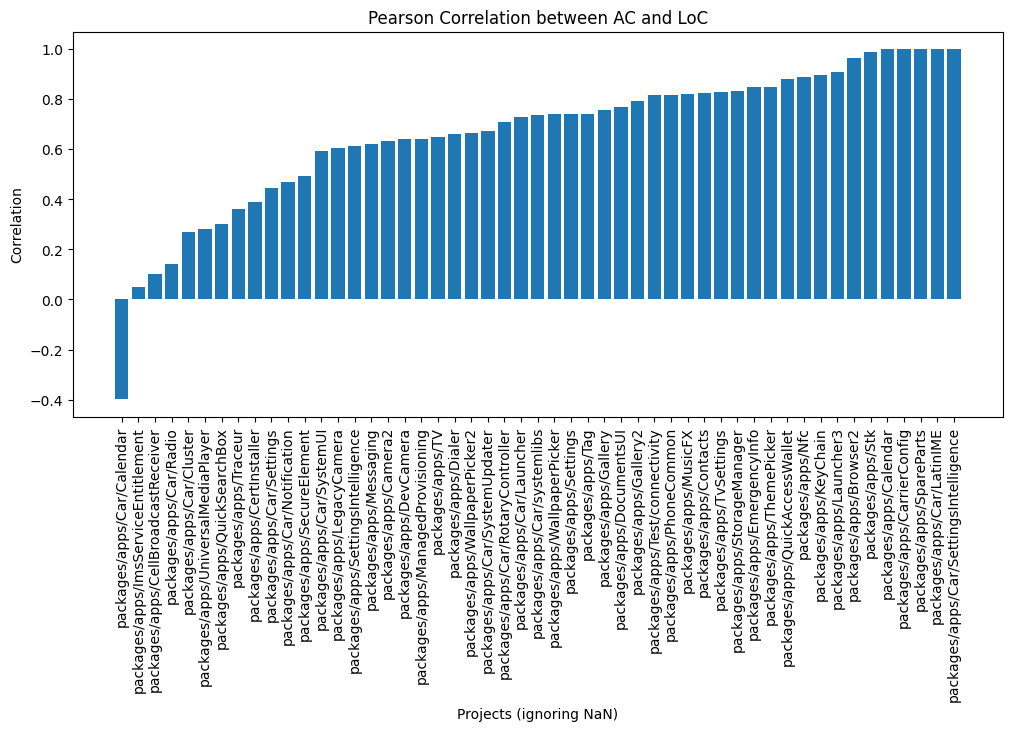

In [16]:
corrs = [c for c in corrs if not np.isnan(c[1])]
s = pd.DataFrame(np.array(corrs), columns=["project_name", "correlation"])
s["correlation"] = s["correlation"].astype(float)
s = s.sort_values(by="correlation")

fig, ax = plt.subplots()
ax.figure.set_figwidth(12)
ax.figure.set_figheight(5)
ax.bar(s["project_name"], s["correlation"])
ax.set_title("Pearson Correlation between AC and LoC")
ax.yaxis.set_label_text("Correlation")
ax.xaxis.set_label_text("Projects (ignoring NaN)")
plt.xticks(rotation=90)
plt.show()

## Filewise analysis

In [17]:
def ac_ck_pipeline(project_name: str):
    df_ck = ck_in_a_project(project_name).groupby("file_path").mean(numeric_only=True).reset_index()
    df_ck["file_path"] = df_ck["file_path"].astype("str")
    df_ck["path"] = df_ck["file_path"]
    df_files = files_in_a_project(project_name)[["path", "loc"]]
    df_files["path"] = df_files["path"].astype(str)
    df_ck.drop(columns=["loc"], inplace=True) # drop loc, use from files instead.

    pd_merged = pd.merge(df_files, df_ck, how="left", on="path")
    df_ac = acs_in_a_project(project_name)[["path", "ac_count"]].groupby("path").agg({"ac_count": "sum"}).reset_index()

    pd_merged = pd.merge(pd_merged, df_ac, how="left", on="path")
    pd_merged.infer_objects(copy=False)
    pd_merged["ac_count"] = pd_merged["ac_count"].astype(float).fillna(0).astype(int)
    pd_merged["loc"] = pd_merged["loc"].astype(int)
    pd_merged.drop(columns=["file_path"], inplace=True)
    return pd_merged


In [18]:
df_correlations = pd.DataFrame()
series = []
for i, project_name in enumerate(apps_set):
    serie = ac_ck_pipeline(project_name).corr(method="pearson", numeric_only=True)["ac_count"]
    serie["project_name"] = project_name
    series.append(serie)
df_correlations = pd.DataFrame.from_records(series)

df_correlations

,loc,cbo,cboModified,fanin,fanout,wmc,dit,noc,rfc,lcom,...,variablesQty,maxNestedBlocksQty,anonymousClassesQty,innerClassesQty,lambdasQty,uniqueWordsQty,modifiers,logStatementsQty,ac_count,project_name
0,0.589418,-0.033454,0.027427,0.145752,-0.033454,0.387217,-0.185267,0.035417,0.208154,0.331839,...,0.141165,0.222639,0.354098,0.359569,0.152339,0.206361,0.014864,NaN,1.0,packages/apps/Car/SystemUI
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,packages/apps/Car/LinkViewer
2,0.851396,-0.073255,0.219293,0.954556,-0.073255,0.950134,-0.412760,NaN,0.561020,0.812008,...,0.941491,0.577115,-0.209390,0.698785,NaN,0.916428,0.155706,NaN,1.0,packages/apps/MusicFX
3,0.691602,0.296260,0.176798,-0.039902,0.296260,0.227462,0.059642,-0.011245,0.438277,-0.009744,...,0.408037,0.322884,0.439057,0.117520,0.207496,0.275596,-0.021345,NaN,1.0,packages/apps/WallpaperPicker2
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,packages/apps/SafetyRegulatoryInfo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,NaN,1.000000,NaN,1.000000,1.000000,NaN,1.0,packages/apps/HTMLViewer
61,0.812289,0.138978,0.079923,-0.017107,0.138978,0.574539,0.057168,-0.115340,0.527236,0.319020,...,0.781087,0.269211,0.008893,0.533670,NaN,0.424066,-0.078326,NaN,1.0,packages/apps/WallpaperPicker
62,0.485437,0.107763,-0.002300,-0.128704,0.107763,0.508055,-0.172130,0.241718,0.234455,0.126255,...,0.505066,0.277556,0.007890,0.280785,0.286940,0.364876,0.145479,NaN,1.0,packages/apps/Car/Radio
63,0.988483,-0.114960,-0.048970,0.333333,-0.114960,0.807656,-0.816497,NaN,0.624010,-0.533081,...,0.855337,0.777778,1.000000,0.333333,NaN,0.088627,-0.297804,NaN,1.0,packages/apps/Music


In [19]:
df_correlations.to_csv("corr_per_project_mean.csv", index=False)

In [20]:
records = []
for app in apps_set:
    df_files = files_in_a_project(app)
    df_ac = acs_in_a_project(app)
    serie_files_with_ac = report_files_with_acs(app)
    records.append({
        "project_name": app,
        "file_qty": df_files.size,
        "loc_sum": df_files["loc"].sum(),
        "files_with_ac_perc": serie_files_with_ac.size / df_files.size
    })
df_metrics = pd.DataFrame.from_records(records)
df_metrics

,project_name,file_qty,loc_sum,files_with_ac_perc
0,packages/apps/Car/SystemUI,780,46453,0.107692
1,packages/apps/Car/LinkViewer,3,111,0.333333
2,packages/apps/MusicFX,21,3037,0.238095
3,packages/apps/WallpaperPicker2,618,34323,0.137540
4,packages/apps/SafetyRegulatoryInfo,3,46,0.000000
...,...,...,...,...
60,packages/apps/HTMLViewer,6,237,0.166667
61,packages/apps/WallpaperPicker,120,6409,0.150000
62,packages/apps/Car/Radio,108,5942,0.148148
63,packages/apps/Music,12,726,0.083333
